In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyprogressivex
from random import randint
from time import time
from pylsd.lsd import lsd

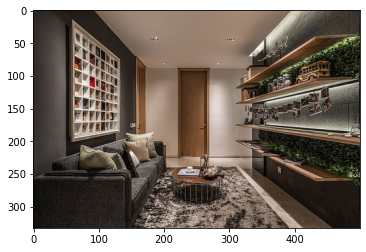

In [57]:
# Load the images
img = cv2.cvtColor(cv2.imread('img/00031591.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

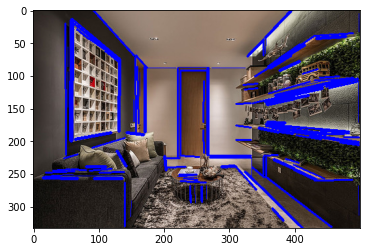

In [58]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
detected_linesegments = lsd(gray)
length_threshold = 20
linesegments = []

#Show image
line_img = img.copy()
for i in range(detected_linesegments.shape[0]):
    # Convert the line to its implicit form
    pt1 = np.array([detected_linesegments[i, 0], detected_linesegments[i, 1]])
    pt2 = np.array([detected_linesegments[i, 2], detected_linesegments[i, 3]])
    v = pt2 - pt1
    line_length = np.linalg.norm(v)

    if line_length < length_threshold:
        continue

    v = v / line_length
    n = np.array([-v[1], v[0]])
    a = n[0]
    b = n[1]
    c = -a * pt1[0] - b * pt1[1]
    linesegments.append(detected_linesegments[i, :])
    
    # Draw the line
    pt1i = (int(detected_linesegments[i, 0]), int(detected_linesegments[i, 1]))
    pt2i = (int(detected_linesegments[i, 2]), int(detected_linesegments[i, 3]))
    width = detected_linesegments[i, 4]
    cv2.line(line_img, pt1i, pt2i, (0, 0, 255), int(np.ceil(width / 2)))
plt.imshow(line_img)

linesegments = np.array(linesegments)

In [59]:
def verify_pyprogressivex(img, lines, threshold = 2.0):        
    vanishing_points, labeling = pyprogressivex.findVanishingPoints(
        np.ascontiguousarray(lines), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.5,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 10,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)    
    return vanishing_points, labeling

In [60]:
t = time()

vanishing_points, labeling = verify_pyprogressivex(img, linesegments[:,0:4], threshold=1.0)
model_number = int(vanishing_points.size / 3)

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  0.004063129425048828  sec
Models found = 2


Drawing the lines assigned to the 1-th vanishing point.
# inliers = 56
Drawing the lines assigned to the 2-th vanishing point.
# inliers = 38


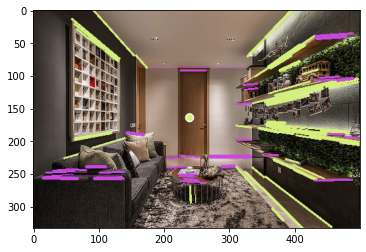

In [64]:
line_img = img.copy()
max_inlier_number = 0

for idx in range(model_number):    
    mask = np.zeros(len(labeling))
    indices = [i for i, e in enumerate(labeling) if e == idx]
    color = (randint(0, 255), randint(0, 255), randint(0, 255))

    vp = vanishing_points[idx]
    vp /= vp[2]
    vp = (int(vp[0]), int(vp[1]))

    print("Drawing the lines assigned to the {}-th vanishing point.".format(int(idx + 1)))
    print(f"# inliers = {len(indices)}")
    
    for i in indices:
        # Draw the line
        pt1i = (int(linesegments[i, 0]), int(linesegments[i, 1]))
        pt2i = (int(linesegments[i, 2]), int(linesegments[i, 3]))
        width = linesegments[i, 4]
        
        cv2.line(line_img, pt1i, pt2i, color, int(np.ceil(width / 2)))
        cv2.circle(line_img, vp, 7, (255, 255, 255), -1)
        cv2.circle(line_img, vp, 5, color, -1)
    
plt.imshow(line_img)